In [1]:
# Grundlegende Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import statsmodels.api as sm
from scipy import stats

In [2]:
# Einstellungen für bessere Plots
plt.rcParams['figure.figsize'] = (10, 6)

# Pandas Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

ds = pd.read_csv(f"{path}/credit_card_transactions.csv")


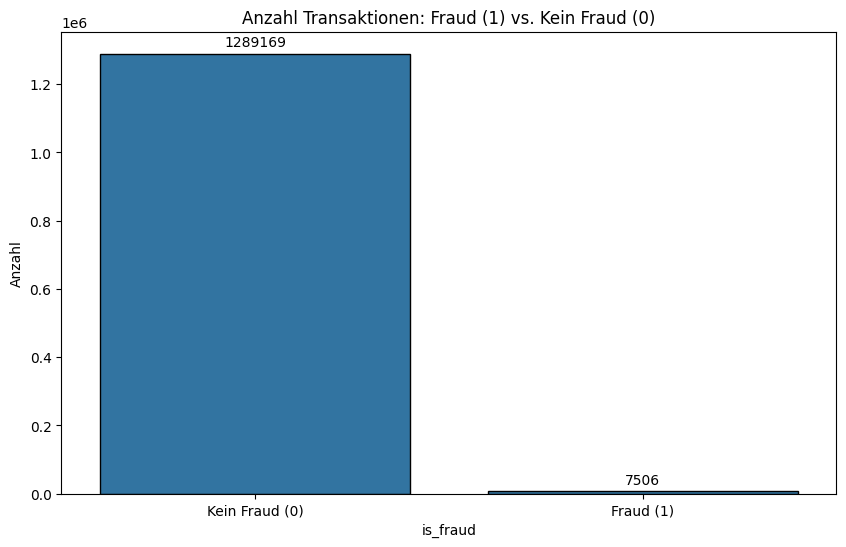

In [4]:
plt.figure()
ax = sns.countplot(x="is_fraud", data=ds, edgecolor="black")

plt.title("Anzahl Transaktionen: Fraud (1) vs. Kein Fraud (0)")
plt.xlabel("is_fraud")
plt.ylabel("Anzahl")
plt.xticks([0, 1], ["Kein Fraud (0)", "Fraud (1)"])

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

In [5]:
# Kategorien-Auflistung der Anzahl Transaktionen
ds["category"].unique()
ds["category"].nunique()
ds["category"].value_counts()

category
gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
misc_pos           79655
misc_net           63287
grocery_net        45452
travel             40507
Name: count, dtype: int64


Wir wollen anschauen, welches Geschlecht in welcher Kategorie mehr Transaktionen durchgeführt hat. Dazu haben wir zuerst Vermutungen zu den Kategorien aufgestellt

- misc_net: Keine Vermutung da dies die Daten von nicht zugeordneten online Transaktionen sind
- misc_pos: Keine Vermutung da dies die Daten von nicht zugeordneten physischen Transaktionen sind
- grocery_pos: Mehr Frauen haben diese Transaktionen durchgeführt
- grocery_net Mehr Frauen haben diese Transaktionen durchgeführt
- entertainment: Mehr Männer haben diese Transaktionen durchgeführt
- gas_transport: Mehr Männer haben diese Transaktionen durchgeführt
- shopping_net: Mehr Frauen haben diese Transaktionen durchgeführt
- shopping_pos: Mehr Frauen haben diese Transaktionen durchgeführt
- food_dining: Mehr Männer haben diese Transaktionen durchgeführt
- personal_care: Mehr Frauen haben diese Transaktionen durchgeführt
- health fitness: Wir denken hier sind beide Geschlechter gleich auf oder die Frauen leicht im mehr.
- travel: Mehr Männer haben diese Transaktionen durchgeführt
- kids_pets: Mehr Männer haben diese Transaktionen durchgeführt
- home: Mehr Männer haben diese Transaktionen durchgeführt

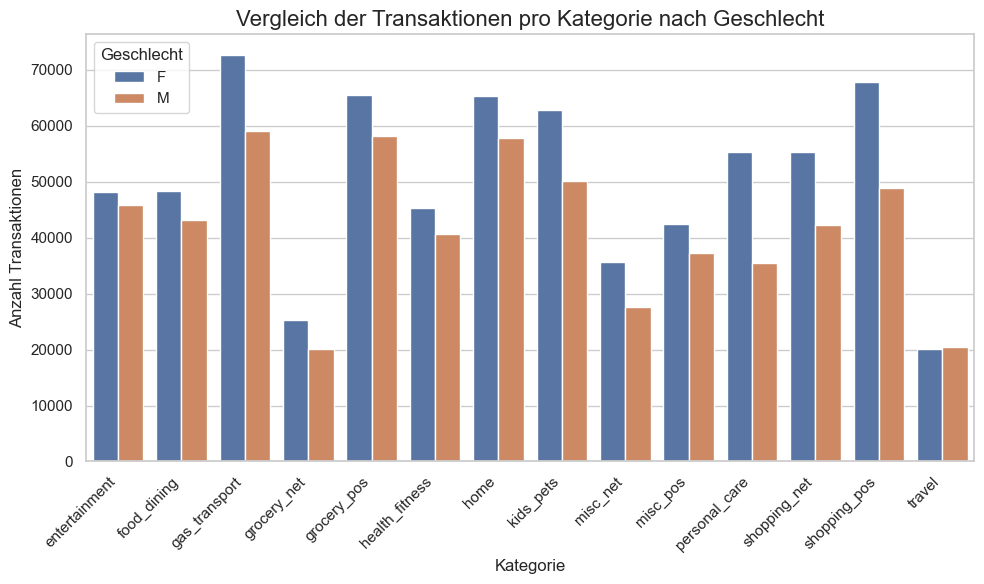

In [6]:
sns.set(style="whitegrid")

# Gruppieren nach Kategorie und Geschlecht und die Anzahl zählen
category_gender_counts = ds.groupby(['category', 'gender']).size().reset_index(name='count')

# Balkendiagramm erstellen
plt.figure()
sns.barplot(x='category', y='count', hue='gender', data=category_gender_counts)

# Diagramm anpassen
plt.title("Vergleich der Transaktionen pro Kategorie nach Geschlecht", fontsize=16)
plt.xlabel("Kategorie", fontsize=12)
plt.ylabel("Anzahl Transaktionen", fontsize=12)
plt.xticks(rotation=45, ha='right')  # x-Achsenbeschriftungen lesbar machen
plt.legend(title='Geschlecht')
plt.tight_layout()

### Evaluierung:

Wir sehen, dass in jeder Kategorie die Frau mehr Transaktionen durchführt als der Mann den einzigen kleinen Unterschied liegt beid er Kategorie travel wo der Mann leicht mehr Transaktionen macht als die Frau.


# Amount Spent

Wir Analysieren die allgemein ausgegebenen Beträge, die Verteilung der Beträge auf die Kategorien und wie die Ausgaben mit dem Geschlecht zusammenhängt.

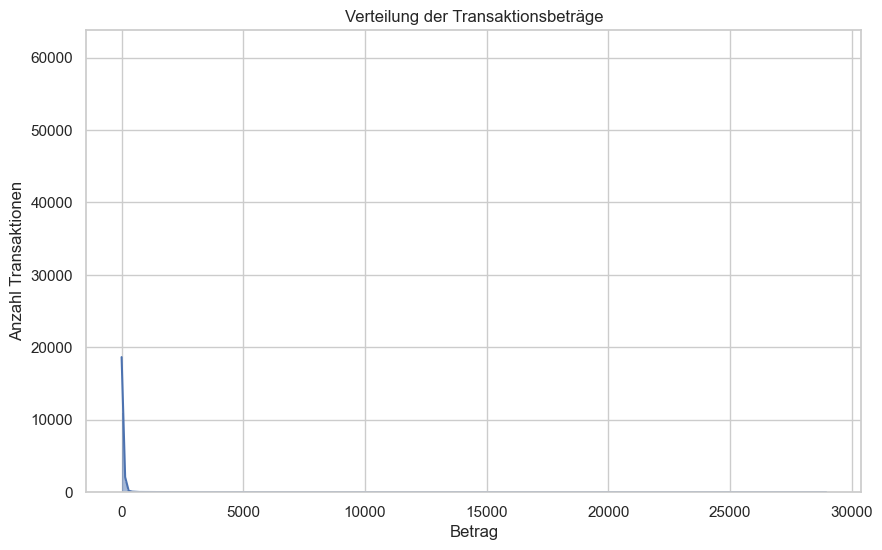

Anzahl Ausreißer: 67290
Z-Score Ausreißer: 12738
Median: 47.52
Mod. Z-Score-Ausreißer: 40359


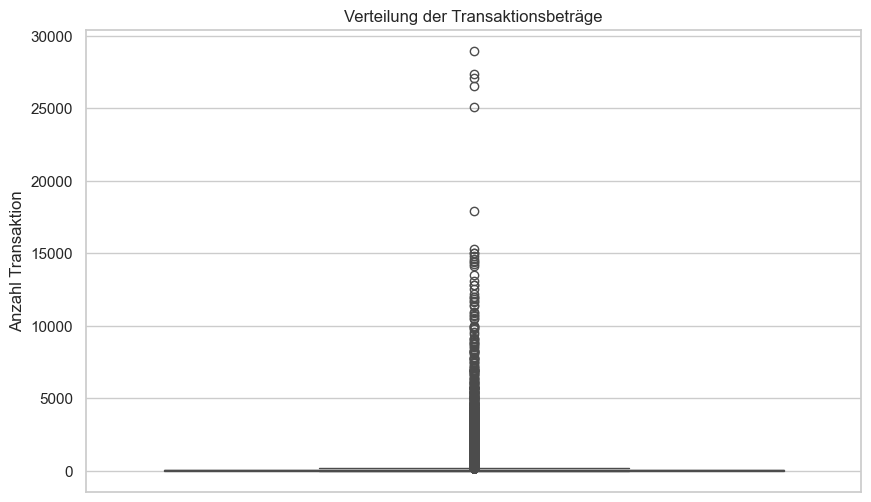

Median: 3.8819760840758493
Mod. Z-Score-Ausreißer: 400


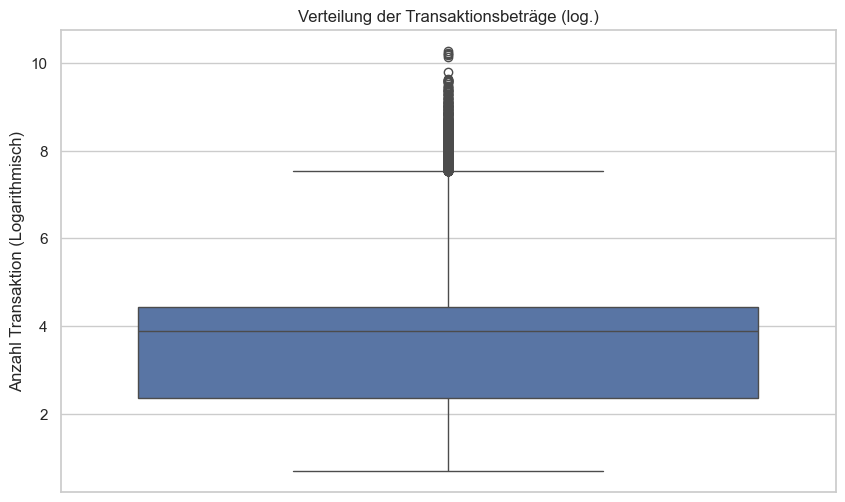

In [7]:
import numpy as np
#we look at the amounts spent over all for the transactions and then we compare the amounts spent by category and then by gender
plt.figure()
sns.histplot(ds['amt'], bins='fd', kde=True)
plt.title("Verteilung der Transaktionsbeträge")
plt.xlabel("Betrag")
plt.ylabel("Anzahl Transaktionen")
plt.show()

# Tukey
Q1 = ds['amt'].quantile(0.25)
Q3 = ds['amt'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - 1.5*IQR
upper_fence = Q3 + 1.5*IQR
outliers = ds[(ds['amt'] < lower_fence) | (ds['amt'] > upper_fence)]
print(f"Anzahl Ausreißer: {len(outliers)}")

# Z-Score
ds['z_score'] = stats.zscore(ds['amt'])
outliers_z = ds[abs(ds['z_score']) > 3]
print(f"Z-Score Ausreißer: {len(outliers_z)}")

# Modifizierter Z-Score (robust gegen Schiefe)
median_amt = ds['amt'].median()
mad_amt = (ds['amt'] - median_amt).abs().median()
ds['mod_z'] = 0.6745 * (ds['amt'] - median_amt) / mad_amt
outliers_modz = ds[ds['mod_z'].abs() > 3.5]
print(f"Median: {median_amt}")
print(f"Mod. Z-Score-Ausreißer: {len(outliers_modz)}")


plt.figure()
sns.boxplot(ds['amt'])
plt.title("Verteilung der Transaktionsbeträge")
plt.ylabel("Anzahl Transaktion")
plt.show()


# LOGARITHMISCHE SKALA
log_amt = np.log1p(ds['amt'])

median_amt = log_amt.median()
mad_amt = (log_amt - median_amt).abs().median()
ds['mod_z'] = 0.6745 * (log_amt - median_amt) / mad_amt
outliers_modz = ds[ds['mod_z'].abs() > 3.5]
print(f"Median: {median_amt}")
print(f"Mod. Z-Score-Ausreißer: {len(outliers_modz)}")


plt.figure()
sns.boxplot(log_amt)
plt.title("Verteilung der Transaktionsbeträge (log.)")
plt.ylabel("Anzahl Transaktion (Logarithmisch)")
plt.show()

Text(0, 0.5, 'Dichte')

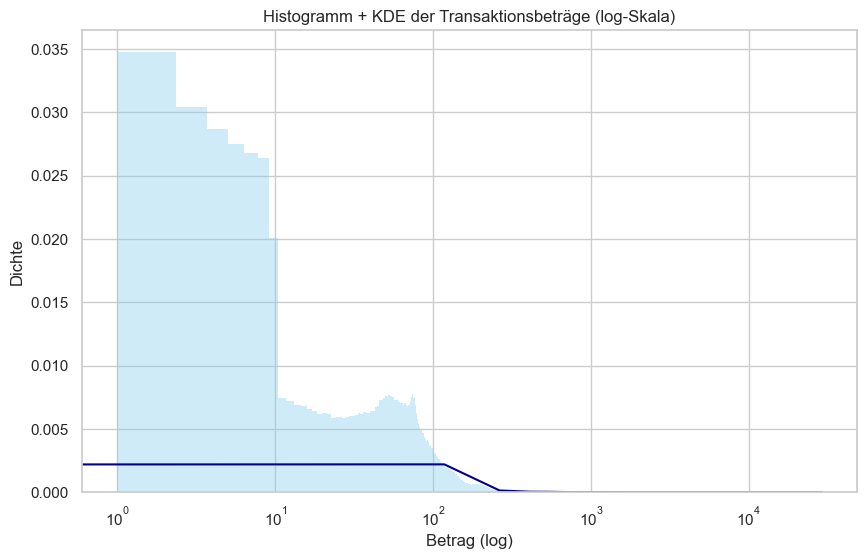

In [8]:
plt.figure()
sns.histplot(ds['amt'], bins='fd', stat='density', alpha=0.4, color='skyblue', edgecolor='black')
sns.kdeplot(ds['amt'], bw_adjust=1.0, color='darkblue')
plt.xscale('log')
plt.title("Histogramm + KDE der Transaktionsbeträge (log-Skala)")
plt.xlabel("Betrag (log)")
plt.ylabel("Dichte")


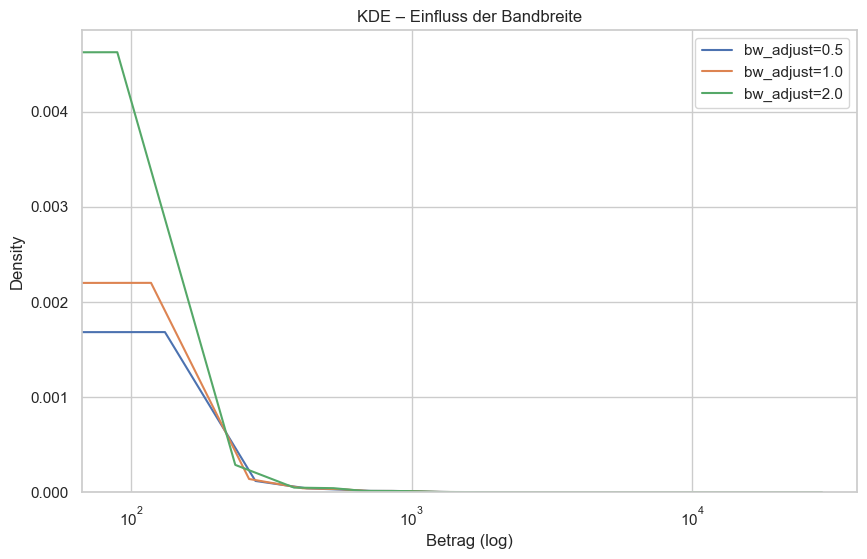

In [9]:
# Vergleich verschiedener Glättungsgrade (bw_adjust)
for bw in [0.5, 1.0, 2.0]:
    sns.kdeplot(ds['amt'], bw_adjust=bw, label=f'bw_adjust={bw}')
plt.xscale('log')
plt.title("KDE – Einfluss der Bandbreite")
plt.xlabel("Betrag (log)")
plt.legend()

Text(0.5, 1.0, 'QQ-Plot der Transaktionsbeträge')

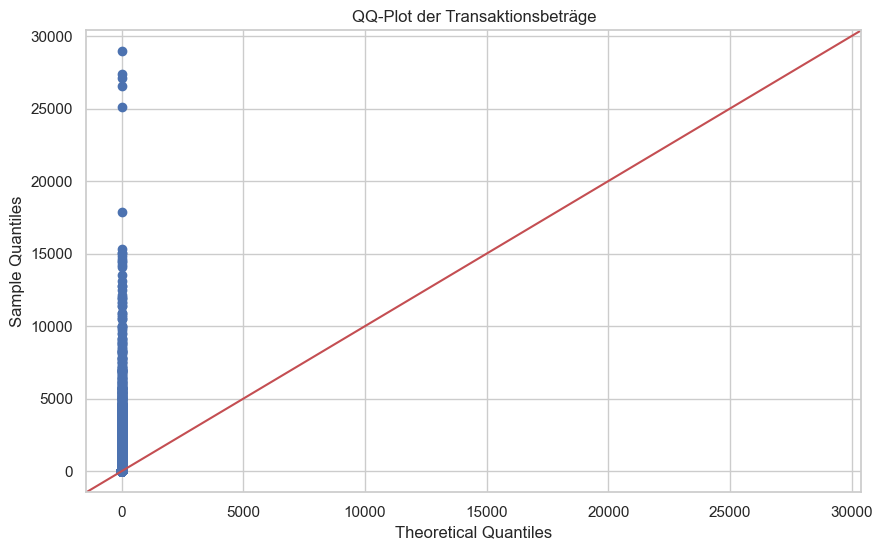

In [10]:
sm.qqplot(ds['amt'], line='45')
plt.title("QQ-Plot der Transaktionsbeträge")

Text(0.5, 1.0, 'QQ-Plot der Transaktionsbeträge')

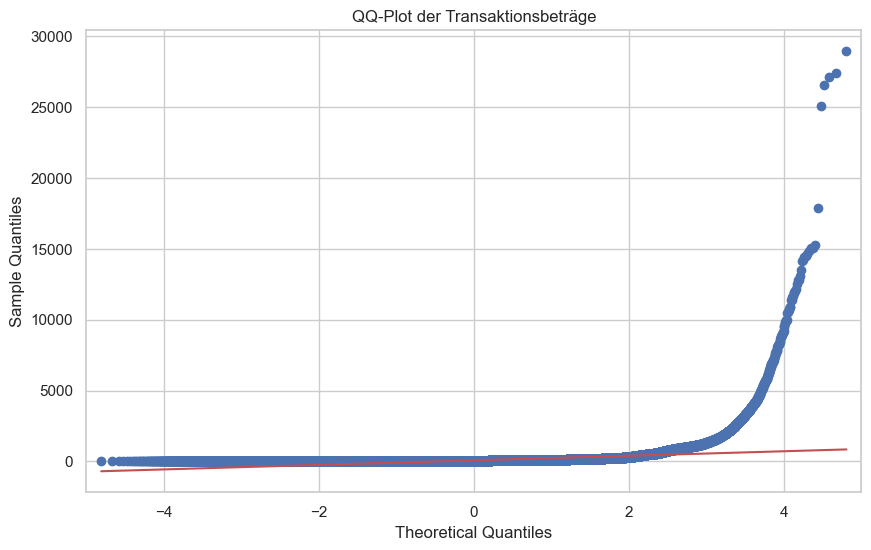

In [11]:
sm.qqplot(ds['amt'], line='s')
plt.title("QQ-Plot der Transaktionsbeträge")

Text(0, 0.5, 'Kumulative Wahrscheinlichkeit')

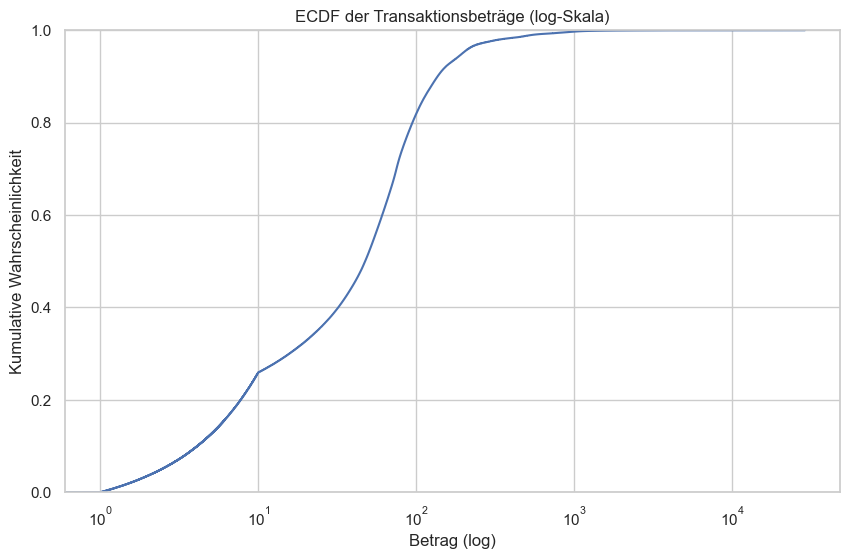

In [12]:
plt.figure()
sns.ecdfplot(data=ds, x='amt')
plt.xscale('log')
plt.title("ECDF der Transaktionsbeträge (log-Skala)")
plt.xlabel("Betrag (log)")
plt.ylabel("Kumulative Wahrscheinlichkeit")

Text(0, 0.5, 'Betrag (Logarithmisch)')

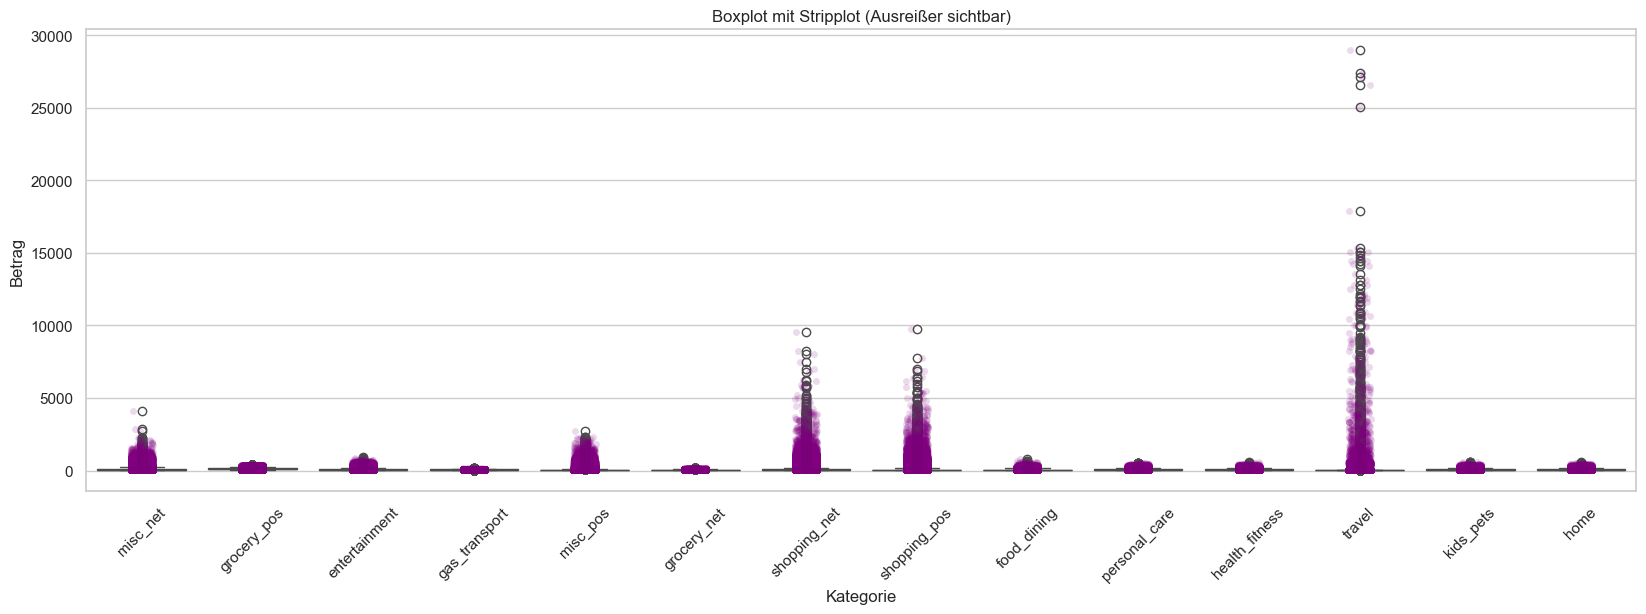

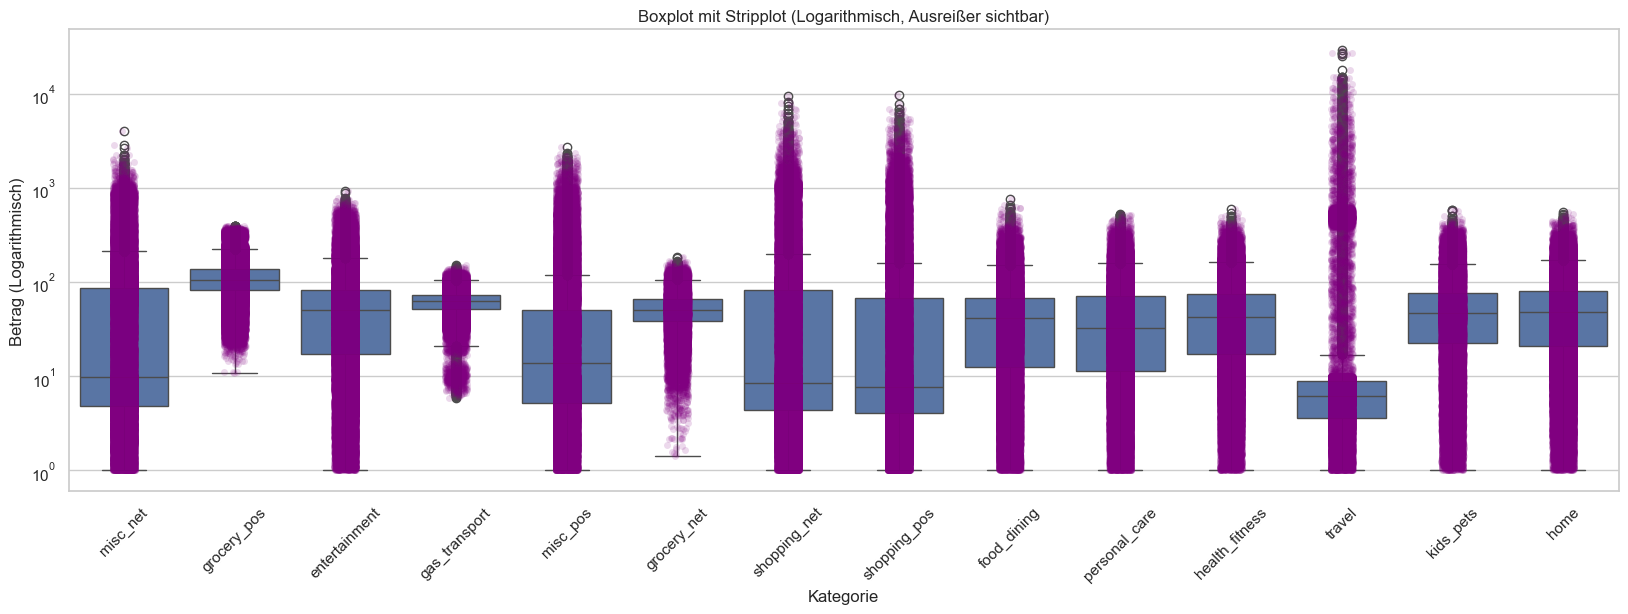

In [13]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=ds, x='category', y='amt')
sns.stripplot(data=ds, x='category', y='amt', color='purple', alpha=0.15, jitter=True)
plt.xticks(rotation=45)
plt.title("Boxplot mit Stripplot (Ausreißer sichtbar)")
plt.xlabel("Kategorie")
plt.ylabel("Betrag")

plt.figure(figsize=(20, 6))
sns.boxplot(data=ds, x='category', y='amt')
sns.stripplot(data=ds, x='category', y='amt', color='purple', alpha=0.15, jitter=True)
plt.xticks(rotation=45)
plt.title("Boxplot mit Stripplot (Logarithmisch, Ausreißer sichtbar)")
plt.xlabel("Kategorie")
plt.yscale("log")
plt.ylabel("Betrag (Logarithmisch)")

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_33626/1273720670.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=ds, x='category', y='amt', hue='gender',  palette='coolwarm', ci=None)


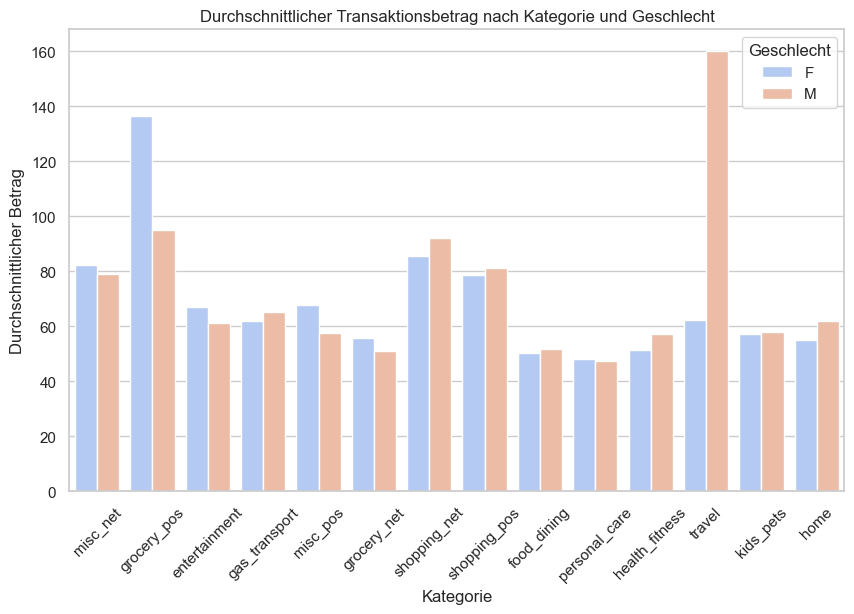

In [14]:
# Durchschnittlicher Betrag pro Kategorie und Geschlecht
plt.figure()
sns.barplot(data=ds, x='category', y='amt', hue='gender',  palette='coolwarm', ci=None)
plt.xticks(rotation=45)
plt.title("Durchschnittlicher Transaktionsbetrag nach Kategorie und Geschlecht")
plt.ylabel("Durchschnittlicher Betrag")
plt.xlabel("Kategorie")
plt.legend(title="Geschlecht")

Text(0, 0.5, 'Kumulative Wahrscheinlichkeit')

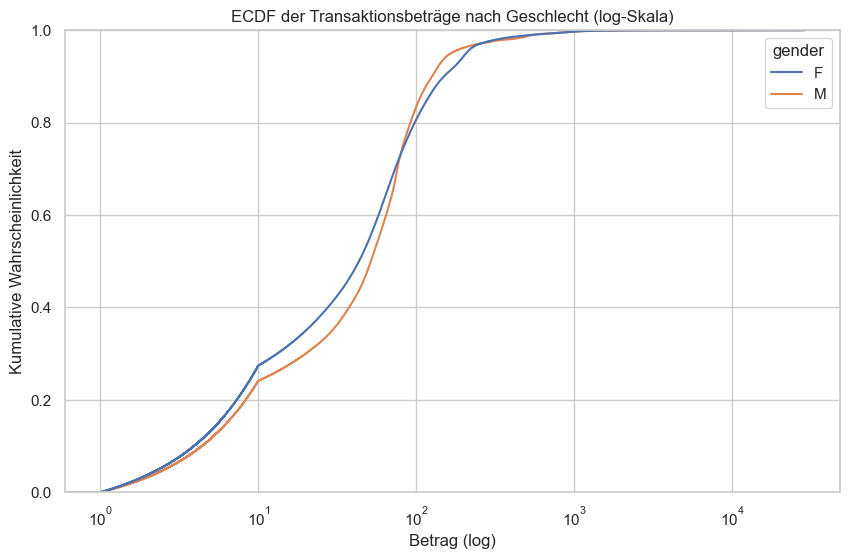

In [15]:
# ECDF nach Geschlecht
plt.figure()
sns.ecdfplot(data=ds, x='amt', hue='gender')
plt.xscale('log')
plt.title("ECDF der Transaktionsbeträge nach Geschlecht (log-Skala)")
plt.xlabel("Betrag (log)")
plt.ylabel("Kumulative Wahrscheinlichkeit")

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_33626/3990455400.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ds, x='gender', y='amt', palette='pastel')


Text(0, 0.5, 'Betrag')

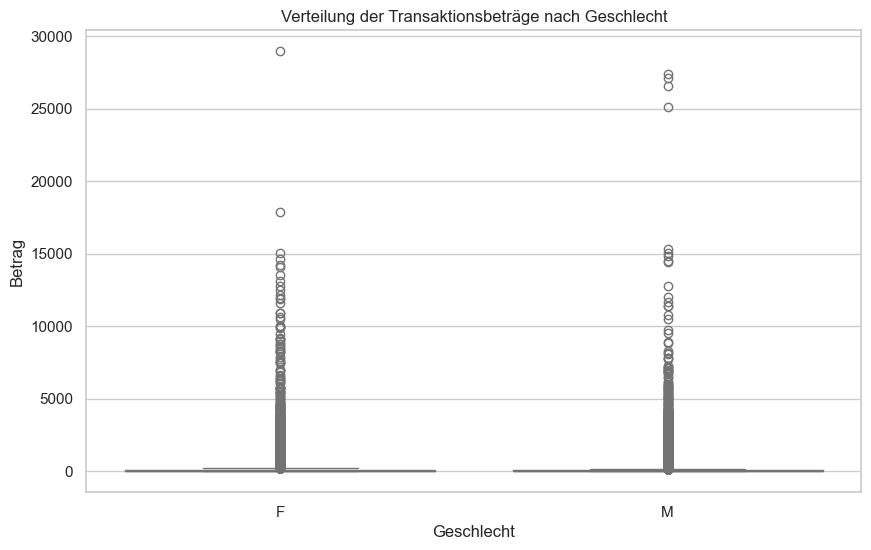

In [16]:
# Boxplot der Beträge nach Geschlecht
plt.figure()
sns.boxplot(data=ds, x='gender', y='amt', palette='pastel')
plt.title("Verteilung der Transaktionsbeträge nach Geschlecht")
plt.xlabel("Geschlecht")
plt.ylabel("Betrag")

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_33626/44646706.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=ds, x='gender', y='amt', inner='quartile', cut=0, bw_adjust=1.0, palette='coolwarm')
/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_33626/44646706.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


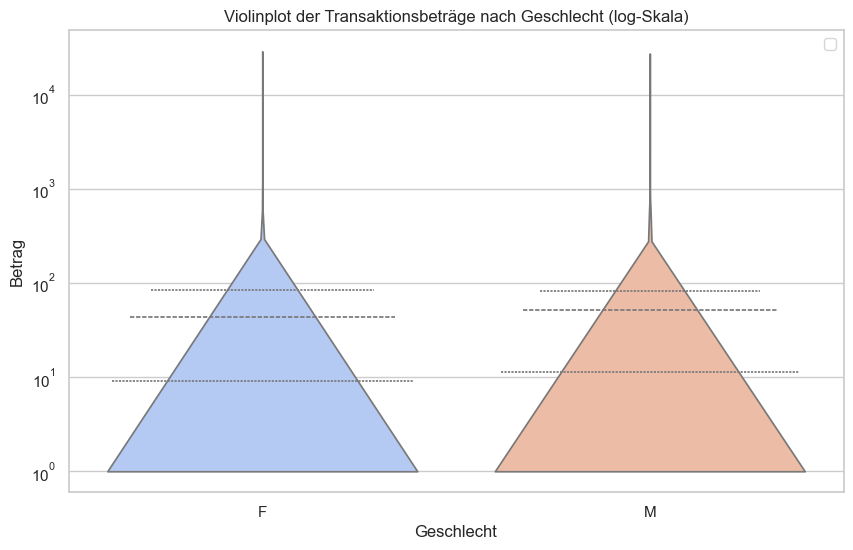

In [17]:
plt.figure()
sns.violinplot(data=ds, x='gender', y='amt', inner='quartile', cut=0, bw_adjust=1.0, palette='coolwarm')
plt.yscale('log')
plt.title("Violinplot der Transaktionsbeträge nach Geschlecht (log-Skala)")
plt.xlabel("Geschlecht")
plt.ylabel("Betrag")
plt.legend()

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_33626/4191077864.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ds, x='gender', y='amt', whis=1.5, showfliers=False, palette='pastel')


Text(0, 0.5, 'Betrag')

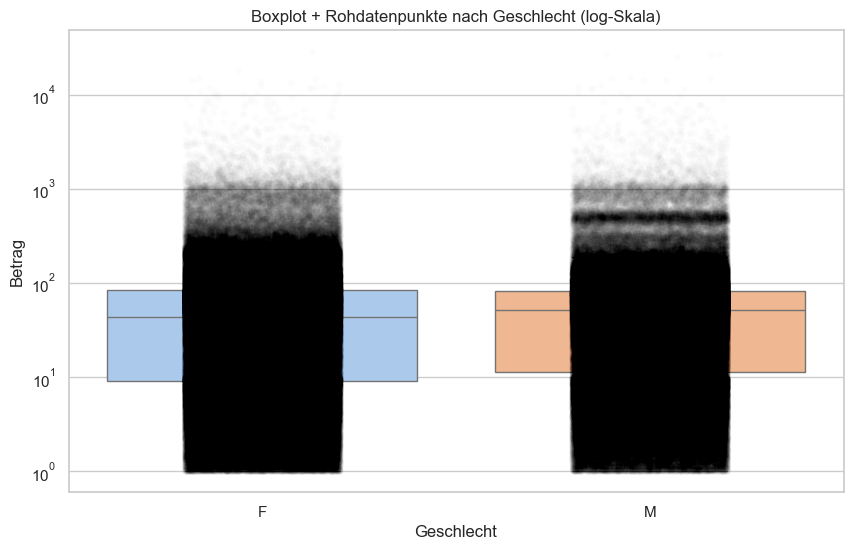

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(data=ds, x='gender', y='amt', whis=1.5, showfliers=False, palette='pastel')
sns.stripplot(data=ds, x='gender', y='amt', color='black', alpha=0.01, jitter=0.2)
plt.yscale('log')
plt.title("Boxplot + Rohdatenpunkte nach Geschlecht (log-Skala)")
plt.xlabel("Geschlecht")
plt.ylabel("Betrag")

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=ds, x='gender', y='amt', whis=1.5, showfliers=False, palette='pastel')
sns.swarmplot(data=ds, x='gender', y='amt')
plt.yscale('log')
plt.title("Boxplot + Rohdatenpunkte nach Geschlecht (log-Skala)")
plt.xlabel("Geschlecht")
plt.ylabel("Betrag")

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_33626/1955405017.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ds, x='gender', y='amt', whis=1.5, showfliers=False, palette='pastel')


KeyboardInterrupt: 

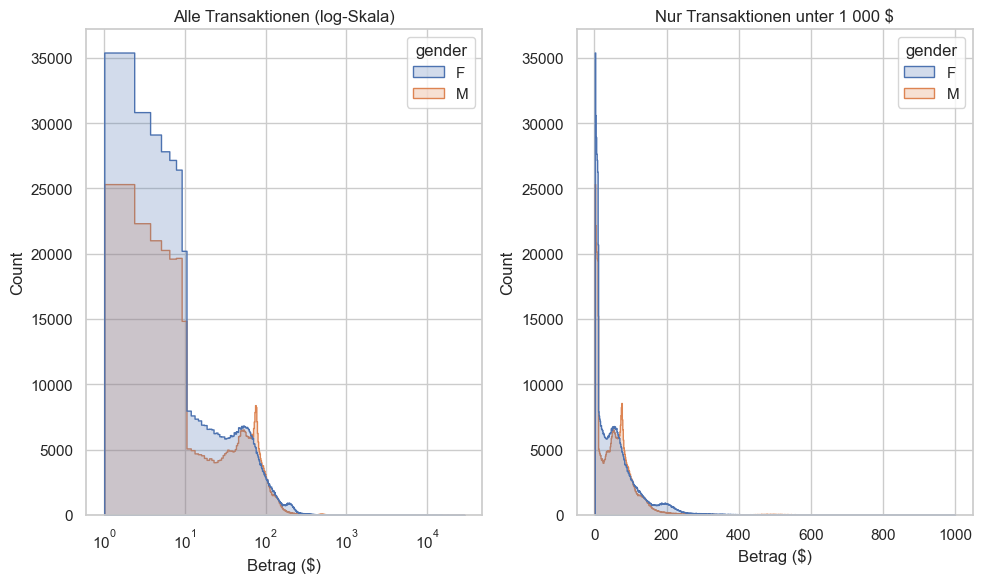

In [ ]:
fig, axes = plt.subplots(1, 2)

sns.histplot(data=ds, x='amt', hue='gender', bins='fd', element='step', ax=axes[0])
axes[0].set_title("Alle Transaktionen (log-Skala)")
axes[0].set_xlabel("Betrag ($)")
axes[0].set_xscale('log')

sns.histplot(data=ds[ds['amt'] < 1000], x='amt', hue='gender', bins='fd', element='step', ax=axes[1])
axes[1].set_title("Nur Transaktionen unter 1 000 $")
axes[1].set_xlabel("Betrag ($)")

plt.tight_layout()